### Load SPEI data

In [262]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def generate_spei_file_name(begin: datetime, end: datetime, directory: str):
    spei_file_paths = []
    current_date = begin
    while current_date <= end:
        spei_file_paths.append(
            f'{directory}/spei_{current_date.strftime("%Y%m")}.nc')
        current_date = current_date + relativedelta(months=1)
    return spei_file_paths

In [263]:
begin = datetime(2000, 1, 1)
end = datetime(2020, 12, 1)
spei_file_paths = generate_spei_file_name(
    begin, end, '/media/jtrvz/1tb/drought_data/spei/spei_db')
len(spei_file_paths)

252

In [264]:
from methods.method1.spei_calc_multi import read_nc_files
# Load the precipitation and temperature data
spei_ds = read_nc_files(spei_file_paths)

## Data preprocessing

In [265]:
from methods.method1.spei_calc_multi import spatial_subset
# Spatial subset for Germany (Europe)
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

In [266]:
# Extract the necessary variables, adjust names as per your dataset
# Rearrange the dimensions of the precipitation xarray.DataArray
spei_ds = spatial_subset(spei_ds, lat_bounds, lon_bounds)
spei_ds

<xarray.Dataset> Size: 310kB
Dimensions:  (time: 252, lon: 19, lat: 16)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-16 2000-02-15 ... 2020-12-16
  * lon      (lon) float64 152B 5.75 6.25 6.75 7.25 ... 13.25 13.75 14.25 14.75
  * lat      (lat) float64 128B 47.25 47.75 48.25 48.75 ... 53.75 54.25 54.75
Data variables:
    crs      (time) int32 1kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    spei     (time, lat, lon) float32 306kB dask.array<chunksize=(1, 16, 19), meta=np.ndarray>
Attributes: (12/18)
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.8
    source:       http://sac.csic.es/spei
    institution:  Consejo Superior de Investigaciones Científicas, CSIC
    title:        Global 1-month SPEI, z-values, 0.5 degree
    version:      2.9
    ...           ...
    date:         Wed Jun 21 14:20:48 2023
    reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...
    history:      Fri Apr 26 15:09:28 2024: cdo splityearmon spei_v2-9_190101...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Prepare data for ML

In [267]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Convert DataArrays to DataFrame
spei_df = spei_ds.to_dataframe()

In [268]:
spei_df.head()

crs      spei
time       lon  lat                 
2000-01-16 5.75 47.25    1 -1.233108
                47.75    1 -1.087101
                48.25    1 -1.008898
                48.75    1 -1.035698
                49.25    1 -1.169314

In [269]:
# Reset index to turn the multi-index into columns
spei_df.reset_index(inplace=True)

In [270]:
# Create lag features
for lag in range(1, 4):  # Here 3 lags are considered
    spei_df[f'spei_lag_{lag}'] = spei_df['spei'].shift(lag)

In [271]:
# Drop rows with missing values due to lag creation
spei_df.dropna(inplace=True)

In [272]:
# Add 'doy' column
spei_df['doy'] = pd.to_datetime(spei_df['time']).dt.dayofyear
spei_df.head()

,time,lon,lat,crs,spei,spei_lag_1,spei_lag_2,spei_lag_3,doy
3,2000-01-16,5.75,48.75,1,-1.035698,-1.008898,-1.087101,-1.233108,16
4,2000-01-16,5.75,49.25,1,-1.169314,-1.035698,-1.008898,-1.087101,16
5,2000-01-16,5.75,49.75,1,-0.719492,-1.169314,-1.035698,-1.008898,16
6,2000-01-16,5.75,50.25,1,-0.859133,-0.719492,-1.169314,-1.035698,16
7,2000-01-16,5.75,50.75,1,-0.938556,-0.859133,-0.719492,-1.169314,16


In [273]:
# Train/test split
train_end = pd.Timestamp('2020-01-01')
train = spei_df[spei_df['time'] < train_end]
test = spei_df[spei_df['time'] >= train_end]

In [274]:
variants = {
    "coords": ['lat', 'lon'],
    "coords_doy": ['lat', 'lon', 'doy'],
    "lag": ['lat', 'lon', 'spei_lag_1', 'spei_lag_2', 'spei_lag_3'],
    "lag_doy": ['lat', 'lon', 'spei_lag_1', 'spei_lag_2', 'spei_lag_3', 'doy'],
}

training_data = {
    "coords": {
        "X_train": train[variants["coords"]],
        "y_train": train['spei'],
        "X_test": test[variants["coords"]],
        "y_test": test['spei'],
    },
    "coords_doy": {
        "X_train": train[variants["coords_doy"]],
        "y_train": train['spei'],
        "X_test": test[variants["coords_doy"]],
        "y_test": test['spei'],
    },
    "lag": {
        "X_train": train[variants["lag"]],
        "y_train": train['spei'],
        "X_test": test[variants["lag"]],
        "y_test": test['spei'],
    },
    "lag_doy": {
        "X_train": train[variants["lag_doy"]],
        "y_train": train['spei'],
        "X_test": test[variants["lag_doy"]],
        "y_test": test['spei'],
    },
}

In [275]:
models = {
    "coords": GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "coords_doy": GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "lag": GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "lag_doy": GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
}

for variant in training_data:
    X_train = training_data[variant]["X_train"]
    y_train = training_data[variant]["y_train"]
    X_test = training_data[variant]["X_test"]
    y_test = training_data[variant]["y_test"]
    model = models[variant]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE for {variant}: {mse}')

MSE for coords: 1.4500626460489168
MSE for coords_doy: 1.461240318773314
MSE for lag: 0.07027998364592485
MSE for lag_doy: 0.07124468274862662


In [276]:
from pydotplus import graph_from_dot_data
from pathlib import Path
from sklearn.tree import export_graphviz
from IPython.display import Image


def create_model_img(model: GradientBoostingRegressor, save_path):
    sub_tree_42 = model.estimators_[42, 0]


    dot_data = export_graphviz(
        sub_tree_42,
        out_file=None, filled=True, rounded=True,
        special_characters=True,
        proportion=False, impurity=False,  # enable them if you want
    )
    graph = graph_from_dot_data(dot_data)
    png = graph.create_png()
    # Save (optional)
    Path(save_path).write_bytes(png)
    # Display
    Image(png)

In [277]:
for variant in models:
    create_model_img(models[variant], f"./output/out_{variant}_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}.png")

## Save models

In [278]:
import joblib

for variant in models:
    model_name = f"model_{variant}_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}"
    joblib.dump(models[variant], f"output/{model_name}.pkl")

## Validate models

In [279]:
def predict_spei(model_path, X_train, lat, lon, spei_lag_1=None, spei_lag_2=None, spei_lag_3=None, doy=None):
    # Load the trained model
    model = joblib.load(model_path)
    if model is None:
        raise ValueError(f"Model not found at {model_path}.")

    # Create a DataFrame with the input values
    data = {
        'lat': [lat],
        'lon': [lon],
    }
    if "doy" in model_path:
        data['doy'] = [doy]
    if "lag" in model_path:
        data['spei_lag_1'] = [spei_lag_1]
        data['spei_lag_2'] = [spei_lag_2]
        data['spei_lag_3'] = [spei_lag_3]

    df = pd.DataFrame(data)
    df = df[X_train.columns]

    # Predict the spei value
    predictions = model.predict(df)

    # Output the prediction
    return predictions[0]

In [280]:
diffs = {
    "coords": {},
    "coords_doy": {},
    "lag": {},
    "lag_doy": {},
}

stats = {
    "coords": {
        "max_diff": None,
        "max_diff_spei": None,
        "max_diff_spei_predicted": None,
        "min_diff": None,
        "min_diff_spei": None,
        "min_diff_spei_predicted": None,
    },
    "coords_doy":
    {
        "max_diff": None,
        "max_diff_spei": None,
        "max_diff_spei_predicted": None,
        "min_diff": None,
        "min_diff_spei": None,
        "min_diff_spei_predicted": None,
    },
    "lag":
    {
        "max_diff": None,
        "max_diff_spei": None,
        "max_diff_spei_predicted": None,
        "min_diff": None,
        "min_diff_spei": None,
        "min_diff_spei_predicted": None,
    },
    "lag_doy":
    {
        "max_diff": None,
        "max_diff_spei": None,
        "max_diff_spei_predicted": None,
        "min_diff": None,
        "min_diff_spei": None,
        "min_diff_spei_predicted": None,
    },
}

max_diff = None
max_diff_spei = None
max_diff_spei_predicted = None

min_diff = None
min_diff_spei = None
min_diff_spei_predicted = None

In [281]:
for _, row in spei_df.iterrows():
    time = row['time']
    if time > pd.Timestamp('2015-02-01') and time < pd.Timestamp('2020-12-01'):
        lat = row['lat']
        lon = row['lon']
        spei = row['spei']
        spei_lag_1 = row['spei_lag_1']
        spei_lag_2 = row['spei_lag_2']
        spei_lag_3 = row['spei_lag_3']
        doy = row['doy']

        for variant in variants.keys():
            X_train = training_data[variant]["X_train"]
            predicted_spei = predict_spei(
                f"output/model_{variant}_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}.pkl",
                X_train,
                lat, lon, spei_lag_1, spei_lag_2, spei_lag_3, doy)

            diff = abs(spei - predicted_spei)

            if max_diff is None or diff > max_diff:
                stats[variant]["max_diff"] = diff
                stats[variant]["max_diff_spei"] = spei
                stats[variant]["max_diff_spei_predicted"] = predicted_spei

            if min_diff is None or diff < min_diff:
                stats[variant]["min_diff"] = diff
                stats[variant]["min_diff_spei"] = spei
                stats[variant]["min_diff_spei_predicted"] = predicted_spei

            diffs[variant][diff] = (spei, predicted_spei)

In [282]:
stats

{'coords': {'max_diff': 1.5685417304703932,
  'max_diff_spei': -1.7144955396652222,
  'max_diff_spei_predicted': -0.1459538091948289,
  'min_diff': 1.5685417304703932,
  'min_diff_spei': -1.7144955396652222,
  'min_diff_spei_predicted': -0.1459538091948289},
 'coords_doy': {'max_diff': 1.6474946502759094,
  'max_diff_spei': -1.7144955396652222,
  'max_diff_spei_predicted': -0.06700088938931287,
  'min_diff': 1.6474946502759094,
  'min_diff_spei': -1.7144955396652222,
  'min_diff_spei_predicted': -0.06700088938931287},
 'lag': {'max_diff': 0.14637911711866702,
  'max_diff_spei': -1.7144955396652222,
  'max_diff_spei_predicted': -1.8608746567838892,
  'min_diff': 0.14637911711866702,
  'min_diff_spei': -1.7144955396652222,
  'min_diff_spei_predicted': -1.8608746567838892},
 'lag_doy': {'max_diff': 0.1349443408653901,
  'max_diff_spei': -1.7144955396652222,
  'max_diff_spei_predicted': -1.8494398805306123,
  'min_diff': 0.1349443408653901,
  'min_diff_spei': -1.7144955396652222,
  'min_di

In [283]:
import numpy as np
from matplotlib import pyplot as plt

# Get the minimum and maximum differences
min_diff = min([stats[variant]["min_diff"] for variant in variants.keys()])
max_diff = max([stats[variant]["max_diff"] for variant in variants.keys()])

# Create range intervals
interval_count = 10
interval_size = (max_diff - min_diff) / interval_count
intervals = [(min_diff + i * interval_size, min_diff +
              (i + 1) * interval_size) for i in range(interval_count)]

# intervals = [(float('-inf'), -3)] + \
#     [(float(i), float(i) + 0.5) for i in range(-3, 4)] + \
#     [(float('inf'), 3)]
# print(intervals)

# Count the number of predictions in each interval
init_val = [0] * interval_count
counts = {
    "coords": init_val.copy(),
    "coords_doy": init_val.copy(),
    "lag": init_val.copy(),
    "lag_doy": init_val.copy(),
}
percentages = {
    "coords": [],
    "coords_doy": [],
    "lag": [],
    "lag_doy": [],
}

x = {
    "coords": {},
    "coords_doy": {},
    "lag": {},
    "lag_doy": {},
}

print(diffs["coords"])
print(diffs["coords_doy"])


{0.36651654463889244: (-0.42690563201904297, -0.06038908738015054), 0.25516950370192476: (-0.34835290908813477, -0.09318340538620999), 0.038349043325819385: (-0.1335100680589676, -0.0951610247331482), 0.041092259433366043: (-0.03136589750647545, -0.07245815693984149), 0.13090439013996635: (-0.20461152493953705, -0.0737071347995707), 0.010338045718585473: (-0.07977835088968277, -0.0694403051710973), 0.24066660776861076: (0.18224218487739563, -0.05842442289121514), 0.18228022257871415: (0.12962758541107178, -0.05265263716764237), 0.03266684400923039: (-0.01998579315841198, -0.05265263716764237), 0.1610619508743054: (-0.216873899102211, -0.05581194822790562), 0.4285932642250092: (-0.4990714192390442, -0.07047815501403498), 0.32529163625224805: (-0.42707133293151855, -0.10177969667927052), 0.2240640442382975: (-0.33332788944244385, -0.10926384520414635), 0.17907539409007833: (-0.26167401671409607, -0.08259862262401774), 0.08981244808072007: (-0.16294193267822266, -0.07312948459750258), 0.0

In [284]:

printed = False
for variant in variants.keys():
    print("Countsvariant:", counts[variant])
    for diff in diffs[variant].keys():
        for i, (start, end) in enumerate(intervals):
            if start <= diff < end:
                if not printed:
                    print(f"{variant}: {i} {diff} in [{start}, {end})")
                printed = True
                # print(f'{variant}: {i} {diff} in [{start}, {end})')
                counts[variant][i] += 1
                if not (start, end) in x[variant]:
                    x[variant][(start, end)] = []
                x[variant][(start, end)].append(diff)
                break
    printed = False

    # print(f'Counts for {variant}: {counts[variant]}')

    # Calculate total number of predictions
    total_predictions = sum(counts[variant])

    # Calculate percentage for each interval
    percentages[variant] = [(count / total_predictions) * 100 for count in counts[variant]]

print(x)

Countsvariant: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
coords: 1 0.36651654463889244 in [0.286199371806442, 0.4374544027474939)
Countsvariant: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
coords_doy: 2 0.45788357170324556 in [0.4374544027474939, 0.5887094336885459)
Countsvariant: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lag: 0 0.208595884358675 in [0.1349443408653901, 0.286199371806442)
Countsvariant: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
lag_doy: 0 0.21941696121843596 in [0.1349443408653901, 0.286199371806442)
{'coords': {(0.286199371806442, 0.4374544027474939): [0.36651654463889244, 0.4285932642250092, 0.32529163625224805, 0.41273172625918314, 0.3473891033659431, 0.42401223013987677, 0.36252119809118954, 0.3317633271745115, 0.36855179740052035, 0.40375926900765446, 0.35882966980098385, 0.3504510184163187, 0.3810947030008197, 0.4320556659698357, 0.35955786307279053, 0.3956534177099693, 0.3569353210166982, 0.34900904100742147, 0.41260177018750205, 0.3806828137888158, 0.4097946573166552, 0.3580060898729891, 0.3695897393121261

coords
[13.997840949982008, 12.67362360561353, 10.888808924073407, 9.989204749910039, 10.658510255487585, 9.881252249010435, 9.37747391147895, 7.736595897804966, 7.8733357322777975, 6.923353724361281]
coords_doy
[14.15948275862069, 14.109195402298852, 11.889367816091955, 11.558908045977013, 11.206896551724139, 10.136494252873565, 7.8951149425287355, 6.242816091954023, 6.637931034482758, 6.163793103448276]
lag
[67.09660083299744, 20.878677952438533, 6.019078328630929, 2.404944242912804, 1.1823189574096467, 0.7389493483810292, 0.5642885933091495, 0.48367593712212814, 0.36275695284159615, 0.2687088539567379]
lag_doy
[67.14612179056326, 20.863019223013847, 5.928216158085764, 2.352466729399113, 1.3173813684635032, 0.7259040193574405, 0.510821346955236, 0.45705067885468476, 0.3898373437289958, 0.30918134157816907]


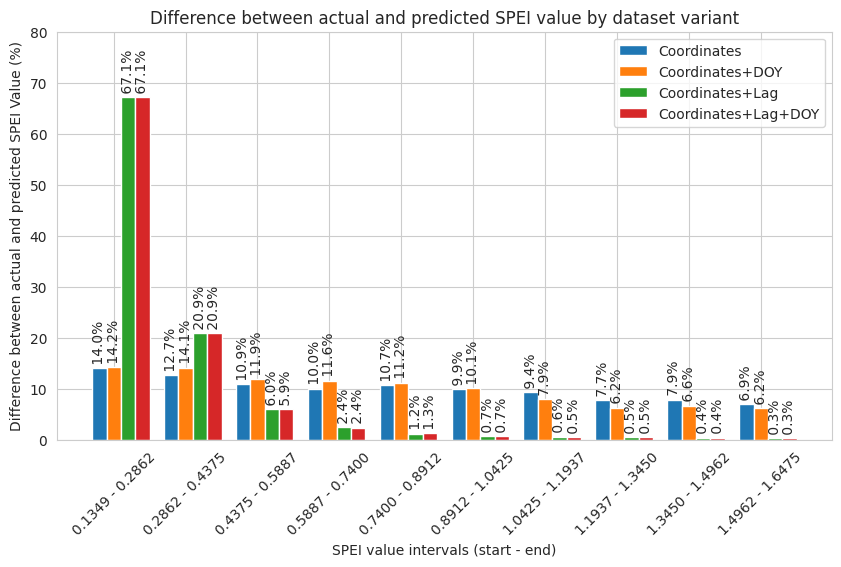

In [285]:

# Define the bar width
bar_width = 0.2

# Define the x coordinates for the bars
x = np.arange(interval_count)

# Create one plot where each variant's percentage for each interval is shown in a different color
plt.figure(figsize=(10, 6))
for i, variant in enumerate(variants.keys()):
    bars = plt.bar(x + i * bar_width, percentages[variant], width=bar_width, label=variant)

    # Add percentage above each bar
    print(variant)
    print(percentages[variant])
    for bar, percentage in zip(bars, percentages[variant]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f' {percentage:.1f}%', ha='center', va='bottom', rotation='vertical')

plt.ylim(0, 80)
plt.xlabel('SPEI value intervals (start - end)')
plt.ylabel('Difference between actual and predicted SPEI Value (%)')
plt.xticks(x + bar_width,
           [f'{start:.4f} - {end:.4f}' for start, end in intervals], rotation=45)
plt.title('Difference between actual and predicted SPEI value by dataset variant')
plt.legend(["Coordinates", "Coordinates+DOY",
           "Coordinates+Lag", "Coordinates+Lag+DOY"])
plt.subplots_adjust(bottom=0.2)
plt.savefig(
    f"output/diff_perc_all_variants_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}.png")

### Box plot
A box plot (or box-and-whisker plot) is a standarized way of displaying the distribution of data based of a five-number summary: minimum, first quartile (Q1), median/second quartile (Q2), third quartile (Q3) and maximum.

1. **Minimum:** The lowest data point excluding any outliers.
2. **First Quartile (Q1):** The median of the lower half of the dataset. This is the point at which 25% of the data lies below it.
3. **Median/Second Quartile (Q2):** The middle value of the dataset which divides the data into two halves. Half of the data points are above the median, and half are below.
4. **Third Quartile (Q3):** The median of the upper half of the dataset. About 75% of the data lies below this value.
5. **Maximum:** The highest data point exlucding any outliers.

Box plots include "whiskers" which extend from the quartiles to the highest and lowest values within 1.5 times the interquartile range (IQR) from the first and third quartiles. Points outside this range are considered outliers and are often indicated with dots, small circles, or stars.

The box itself contains the middle 50% of the data, highlighting the central tendency and spread of the values, while the whiskers show the range. This makes box plots very useful for comparing distributions and spotting outliers in data across different categories.

In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {}
translations = {
    "coords": "Coordinates",
    "coords_doy": "Coordinates+\nDOY",
    "lag": "Coordinates+\nLag",
    "lag_doy": "Coordinates+\nLag+\nDOY",
}

for variant in variants.keys():
    predicted_spei_vals = [value[1] for value in diffs[variant].values()]
    data[translations[variant]] = predicted_spei_vals[:18041]
df = pd.DataFrame(data)

In [287]:
vals, names, xs = [], [], []
for i, col in enumerate(df.columns):
    vals.append(df[col].values)
    names.append(col)
    # adds jitter to the data points - can be adjusted
    xs.append(np.random.normal(i + 1, 0.04, df[col].values.shape[0]))


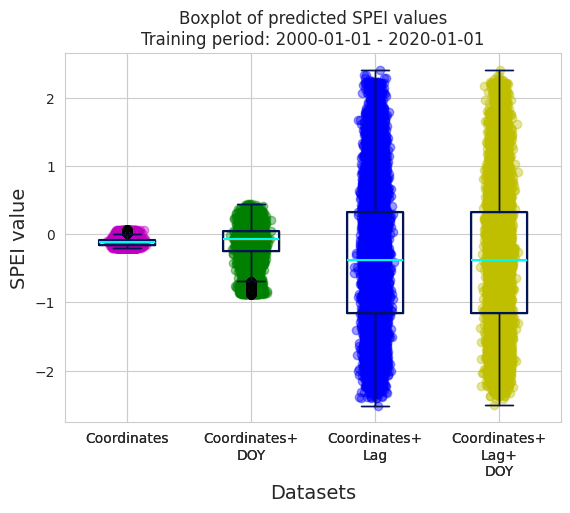

In [288]:
plt.boxplot(vals, labels=names)
palette = ['m', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)

##### Set style options here #####
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#01FBEE')

plt.boxplot(vals, labels=names, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, flierprops=flierprops, medianprops=medianprops, showmeans=False)

plt.title(f"Boxplot of predicted SPEI values\nTraining period: {begin.strftime('%Y-%m-%d')} - {train_end.strftime('%Y-%m-%d')}")
plt.xlabel("Datasets", fontweight='normal', fontsize=14)
plt.ylabel("SPEI value", fontweight='normal', fontsize=14)

plt.savefig(f"./output/boxplot_all_variants_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}.png")

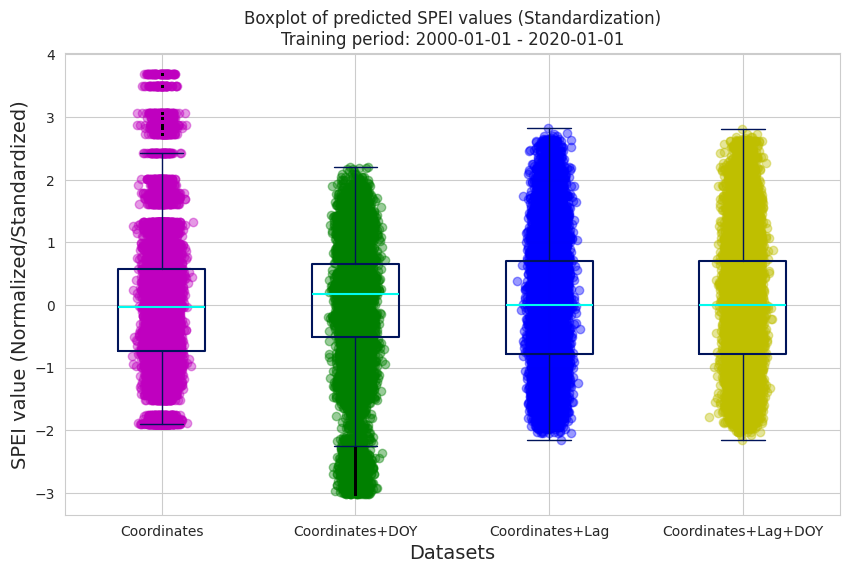

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

translations = {
    "coords": "Coordinates",
    "coords_doy": "Coordinates+DOY",
    "lag": "Coordinates+Lag",
    "lag_doy": "Coordinates+Lag+DOY",
}

data = {}
for variant in variants.keys():
    predicted_spei_vals = [value[1] for value in diffs[variant].values()]
    data[translations[variant]] = predicted_spei_vals[:18041]

# Creating DataFrame
df = pd.DataFrame(data)

# Normalize or Standardize the data

# Normalization
# normalized_df = (df - df.min()) / (df.max() - df.min())
# normalized_df = (df - df.min()) / (df.max() - df.min())
# df_to_plot = normalized_df
# manipulation_method = "Normalized"

# Standardization
standardized_df = (df - df.mean()) / df.std()
df_to_plot = standardized_df
manipulation_method = "Standardization"

# Plot preparation
vals, names, xs = [], [], []
for i, col in enumerate(df_to_plot.columns):
    vals.append(df_to_plot[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_to_plot[col].values.shape[0]))

# Plotting
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Boxplot properties
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#01FBEE')

plt.boxplot(vals, labels=names, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, flierprops=flierprops, medianprops=medianprops, showmeans=False)
palette = ['m', 'g', 'b', 'y']
for x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha=0.4, color=c)

plt.title(f"Boxplot of predicted SPEI values ({manipulation_method})\nTraining period: {begin.strftime('%Y-%m-%d')} - {train_end.strftime('%Y-%m-%d')}")
plt.xlabel("Datasets", fontweight='normal', fontsize=14)
plt.ylabel("SPEI value (Normalized/Standardized)",
           fontweight='normal', fontsize=14)
plt.savefig(
    f"./output/boxplot_all_variants_{begin.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}_{manipulation_method.lower()}.png")